In [1]:
from pathlib import Path
from typing import Dict, Tuple, List, Iterable, Mapping, Optional, Sequence
import numpy as np
from matplotlib import pyplot as plt
from itertools import combinations

# --- Configure the runs you want to inspect ---------------------------------
RUNS_DIR = Path("/home/castedo/Desktop/hopfield runs/gonzaga_28_nov_works_small_angle")
AMPAR_VALUES: List[float] = [1.0,0.63]
RIN_VALUES: List[float] = [1.0, 1.22]
ETA_VALUES: List[float] = [0.1]
TEMP_VALUES: List[float] = [0.0, 0.01,0.05]
IDIR_VALUES: List[float] = [0.5, 0.5003, 0.5005, 0.501, 0.503, 0.505, 0.51]
TRIAL_INDICES: List[int] = list(range(20))  # trial00 … trial19
# ----------------------------------------------------------------------------

def run_id(ampar: float, rin: float,sigma_temp:float, sigma_eta: float, idir: float, trial: int) -> str:
    """Build folder name for a simulation run."""
    suffix =""# "_gain_scan_1_1" if ampar == 1.0 else "_gain_scan_063_122"
    return f"g{ampar:.3f}_rin{rin:.3f}_sigmatemp{sigma_temp:.3f}_sigmaeta{sigma_eta:.3f}_idir{idir:.6f}_trial{trial:02d}{suffix}"


def load_state_matrix(folder: Path) -> np.ndarray:
    """Load a single run’s state history as neurons × generations."""
    history_file = folder / "state_history.npy"
    if not history_file.exists():
        raise FileNotFoundError(f"Missing state history file: {history_file}")
    states = np.load(history_file)  # generations × neurons
    if states.ndim != 2:
        raise ValueError(f"Expected 2‑D array in {history_file}, got {states.shape}")
    return states.T  # neurons × generations


def build_state_tensors(
    runs_dir: Path = RUNS_DIR,
    ampar_values: Iterable[float] = AMPAR_VALUES,
    rin_values: Iterable[float] = RIN_VALUES,
    eta_values: Iterable[float] = ETA_VALUES,
    temp_values: Iterable[float] = TEMP_VALUES,
    idir_values: Iterable[float] = IDIR_VALUES,
    trials: Iterable[int] = TRIAL_INDICES,
) -> Dict[Tuple[float, float, float, float], np.ndarray]:
    """
    Return tensors keyed by (ampar, rin, sigma_temp, sigma_eta):
      shape = (neurons, generations, trials, idir)
    """
    tensors: Dict[Tuple[float, float, float, float], np.ndarray] = {}
    for ampar in ampar_values:
        for rin in rin_values:
            if (ampar==1.0 and rin==1.22) or (ampar==0.63 and rin==1.0):
                continue
            for sigma_temp in temp_values:
                for sigma_eta in eta_values:
                    idir_blocks = []
                    for idir in idir_values:
                        trial_blocks = []
                        for trial in trials:
                            folder = runs_dir / run_id(ampar, rin, sigma_temp, sigma_eta, idir, trial)
                            trial_blocks.append(load_state_matrix(folder))
                        trial_cube = np.stack(trial_blocks, axis=2)  # neurons × generations × trials
                        idir_blocks.append(trial_cube)
                    tensors[(ampar, rin, sigma_temp, sigma_eta)] = np.stack(idir_blocks, axis=3)  # neurons × generations × trials × idir
    return tensors

In [75]:
def smooth_state(state: np.ndarray, window_size: int = 5) -> np.ndarray:
    """
    Rolling mean over generations axis (axis=1); keeps other dims.
    Expects shape (neurons, generations, trials, idir).
    """
    if window_size < 1:
        raise ValueError("window_size must be >= 1")
    cumsum = np.cumsum(state, axis=1)
    cumsum[:, window_size:] = cumsum[:, window_size:] - cumsum[:, :-window_size]
    return cumsum[:, window_size - 1:] / window_size

def compute_snr_per_mode(
    state: np.ndarray,
    idir_1: float,
    idir_2: float,
    ) -> Tuple[np.ndarray, np.ndarray]:
    """
    Compute per-trial/per-angle SNR and eigenvalues.
    state shape: (neurons, generations, trials, idir)
    idir_values: iterable of idir values aligned with the last dim of `state`.
    Returns:
      snr_per_mode: trials × neurons × idir
      evals_per_mode: trials × neurons × idir
    """
    neurons, _, trials, idirs = state.shape

    snr_per_mode = np.zeros((trials, neurons))
    evals_per_mode = np.zeros((trials, neurons))
    angle =  np.flatnonzero(np.isclose(IDIR_VALUES, idir_1))[0]
    other_angle = np.flatnonzero(np.isclose(IDIR_VALUES, idir_2))[0]
    for trial in range(trials):
        delta_mu = state[:, :, trial, angle].mean(axis=1) - state[:, :, trial, other_angle].mean(axis=1)
        covariance = np.cov(state[:, :, trial, angle])
        evals, evecs = np.linalg.eigh(covariance)
        for k in range(evals.shape[0]):
            pc = evecs[:, k]
            signal_proj = np.dot(delta_mu, pc)  # optional: / np.linalg.norm(delta_mu)
            snr_per_mode[trial, k] = signal_proj ** 2  # optional: / evals[k]
            evals_per_mode[trial, k] = evals[k]

    return snr_per_mode, evals_per_mode


def compute_snr_per_mode2(
    state: np.ndarray,
    idir_1: float,
    idir_2: float,
    ) -> Tuple[np.ndarray, np.ndarray]:
    """
    Compute per-trial/per-angle SNR and eigenvalues.
    state shape: (neurons, generations, trials, idir)
    idir_values: iterable of idir values aligned with the last dim of `state`.
    Returns:
      snr_per_mode: trials × neurons × idir
      evals_per_mode: trials × neurons × idir
    """
    neurons, _, trials, idirs = state.shape
    #collapse trial onto generation axis
    state = state.reshape((neurons, -1, idirs))
    snr_per_mode = np.zeros(( neurons))
    evals_per_mode = np.zeros((neurons))
    angle =  np.flatnonzero(np.isclose(IDIR_VALUES, idir_1))[0]
    other_angle = np.flatnonzero(np.isclose(IDIR_VALUES, idir_2))[0]
    delta_mu = state[:, :, angle].mean(axis=1) - state[:, :, other_angle].mean(axis=1)
    covariance = np.cov(state[:, :, angle])
    evals, evecs = np.linalg.eigh(covariance)

    snr_1= delta_mu.T @ np.linalg.pinv(covariance) @ delta_mu
    for k in range(evals.shape[0]):
        pc = evecs[:, k]
        signal_proj = np.dot(delta_mu, pc)  # optional: / np.linalg.norm(delta_mu)
        snr_per_mode[k] = signal_proj ** 2  # optional: / evals[k]
        evals_per_mode[k] = evals[k]

    return snr_per_mode, evals_per_mode, snr_1, delta_mu

def compute_snr_per_delta(state: np.ndarray, idir_values: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    state: (neurons, generations, trials, idir)
    idir_values: array-like of length idir
    Returns:
        deltas: (num_pairs * trials,) absolute ΔIdir for each trial/pair
        snr:    (num_pairs * trials,) δ^T C^{-1} δ for each trial/pair
    """
    neurons, _, trials, idirs = state.shape
    if len(idir_values) != idirs:
        raise ValueError("len(idir_values) must match state.shape[3]")

    # mean over generations → shape (neurons, trials, idir)
    means = state.mean(axis=1)


    deltas, snrs = [], []

    # use combinations to avoid duplicate (i, j) vs (j, i); include both if you prefer symmetry
    for idir_i, idir_j in combinations(range(idirs), 2):
        delta_idir = abs(idir_values[idir_i] - idir_values[idir_j])
        delta_mu = means[:, :, idir_i] - means[:, :, idir_j]  # (neurons, trials)

        for trial in range(trials):
            try:
                evals, evecs = np.linalg.eigh(np.cov(state[:, :, trial, idir_i], ddof=1))
                proj = evecs.T @ delta_mu[:, trial]      # (neurons,)
                snr_trial = np.sum((proj ** 2) / (evals+1e-12))
                deltas.append(delta_idir)
                snrs.append(snr_trial)
            except np.linalg.LinAlgError:
                continue

            # if you also want the symmetric direction, add this block:
            # evals_b, evecs_b = eig_cache[trial][idir_j]
            # proj_b = evecs_b.T @ (-delta_mu[:, trial])  # negative delta
            # snr_b = np.sum((proj_b ** 2) / (evals_b))
            # deltas.append(delta_idir)
            # snrs.append(snr_b)

    return np.asarray(deltas), np.asarray(snrs)


def overlap_function(tensors, ampar, rin, sigma_eta, sigma_temp, idir1, idir2,k=2, window_size=100):
    state1 = tensors[ampar, rin, sigma_temp,sigma_eta]
    # smoothed_state1 = smooth_state(state1, window_size = 100) #################################################3 WINDOW SIZE TO BE MODIFIED

    # average over every 10 generations and then save this
    average_size = window_size
    n_neurons, n_generations, n_trials, n_idir = state1.shape
    n_blocks = n_generations // average_size  # integer division
    cut = n_blocks * average_size             # how many generations to keep

    data_trimmed = state1[:, :cut, :, :]
    data_reshaped = data_trimmed.reshape(n_neurons, n_blocks, average_size, n_trials, n_idir)
    data_avg = data_reshaped.mean(axis=2)

    

    overlap, evals, snr_1, delmu = compute_snr_per_mode2(data_avg,idir_1=idir1,idir_2 = idir2)
    for _ in range(k):
        max_idx = np.argmax(evals)#, axis=1)
        evals = np.delete(evals, max_idx)#, axis=1)
        overlap = np.delete(overlap, max_idx)#, axis=1)

    # Compute means across animals
    # mean_evals = evals.mean(axis=0)
    # mean_overlap = overlap.mean(axis=0)
    # mean_evals = evals.flatten()
    # mean_overlap = overlap.flatten()
    # mask = mean_evals > 1e-10
    # mean_evals = mean_evals[mask]
    # mean_overlap = mean_overlap[mask]

    mean_evals = evals[:]
    mean_overlap = overlap[:]
    # Linear fit
    a, b = np.polyfit(mean_evals, mean_overlap, deg=1)

    # Generate smooth line
    xfit = np.linspace(mean_evals.min(), mean_evals.max(), 200)
    yfit = a * xfit + b

    return mean_evals, mean_overlap, xfit, yfit, a, b, snr_1, delmu


def snr_delta_function(tensors, ampar, rin, sigma_eta, sigma_temp):
    state1 = tensors[ampar, rin, sigma_temp,sigma_eta]
    smoothed_state1 = smooth_state(state1, window_size = 5)
    deltas, snrs = compute_snr_per_delta(smoothed_state1, np.array(IDIR_VALUES))

    unique_deltas = np.unique(deltas)
    avg_snrs = []
    error_snrs = []
    for delta in unique_deltas:
        snr_values = snrs[deltas == delta]
        avg_snrs.append(np.mean(snr_values))
        error_snrs.append(np.std(snr_values) / np.sqrt(len(snr_values)))

    return unique_deltas, np.array(avg_snrs), np.array(error_snrs)

In [3]:
tensors = build_state_tensors()

KeyError: (1, 1, 0.1, 0.1)

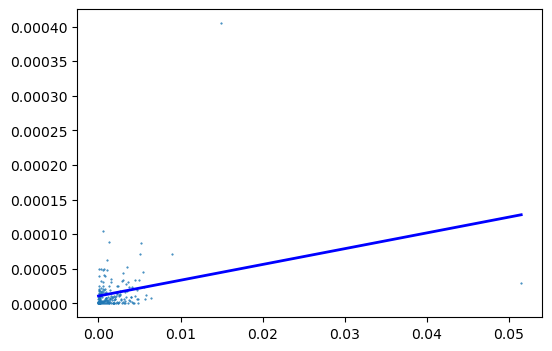

In [6]:
fig, ax = plt.subplots(figsize=(6, 4))
size = 100
k_val = 4
angle_2 = 0.501
mean_evals, mean_overlap, xfit, yfit, a, b, snrog1= overlap_function(
    tensors, ampar=1.0, rin=1.0, sigma_temp=0.0,sigma_eta=0.1,  idir1=0.5, idir2=angle_2, k=k_val, window_size=size
)
ax.plot(mean_evals, mean_overlap, 'o', markersize=0.5)
ax.plot(xfit, yfit, "-", color="blue", lw=2)
snr_1 = np.sum(mean_overlap/mean_evals)

mean_evals, mean_overlap, xfit, yfit, a, b, snrog2 = overlap_function(
    tensors, ampar=1, rin=1, sigma_temp=0.1,sigma_eta=0.1,  idir1=0.5, idir2=angle_2,k=k_val, window_size=size
)
ax.plot(mean_evals, mean_overlap, 'o', markersize=0.5)
ax.plot(xfit, yfit, "-", color="red", lw=2)

ax.set_xlabel("Eigenvalue")
ax.set_ylabel("Overlap")
fig.tight_layout()
plt.show()
snr_2 = np.sum(mean_overlap/mean_evals)
print(snr_1/snr_2)


5.553478959851611


[]

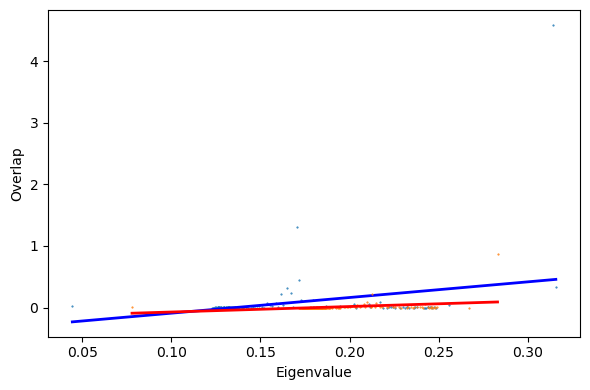

In [156]:
fig, ax = plt.subplots(figsize=(6, 4))

angle_2 = 0.8
mean_evals, mean_overlap, xfit, yfit, a, b = overlap_function(
    tensors, ampar=1.0, rin=1.0, sigma_temp=0.0,sigma_eta=0.1,  idir1=0.5, idir2=angle_2, k=k_val, window_size=size
)
ax.plot(mean_evals, mean_overlap, 'o', markersize=0.5)
ax.plot(xfit, yfit, "-", color="blue", lw=2)
snr_1 = np.sum(mean_overlap/mean_evals)

mean_evals, mean_overlap, xfit, yfit, a, b = overlap_function(
    tensors, ampar=1, rin=1, sigma_temp=0.1,sigma_eta=0.1,  idir1=0.5, idir2=angle_2,k=k_val, window_size=size
)
ax.plot(mean_evals, mean_overlap, 'o', markersize=0.5)
ax.plot(xfit, yfit, "-", color="red", lw=2)

ax.set_xlabel("Eigenvalue")
ax.set_ylabel("Overlap")
fig.tight_layout()
snr_2 = np.sum(mean_overlap/mean_evals)
print(snr_1/snr_2)
plt.plot()

0.4026039253283479
Dmu norm ampar=0.63: 0.2166997
Dmu norm ampar=1.0: 0.30824688


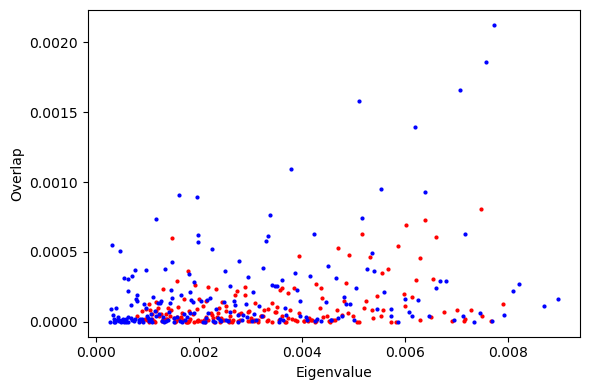

Participation ratio ampar=0.63: 151.69690178002972
Participation ratio ampar=1.0: 125.80622018347702
participation ratio FR/CTR: 1.205798104090509
Mean_Eigval_Ratio FR/CTR: 1.1371029758876299


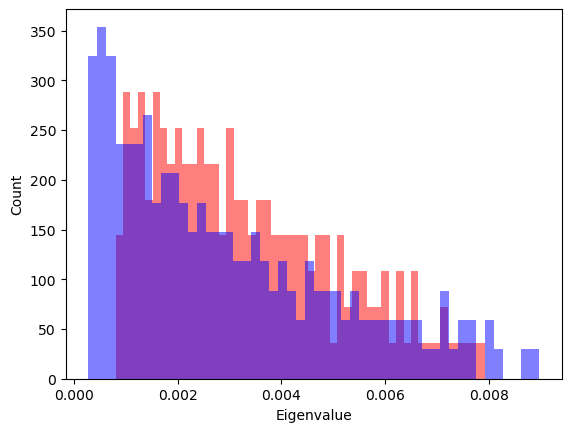

In [94]:
#TEST DIFFERENT TEMPS
fig, ax = plt.subplots(figsize=(6, 4))
size = 50
k_val = 5
angle_2 = 0.51

sig_temp1 = 0.05
sig_temp2 = 0.0
sig_eta = 0.1

mean_evals1, mean_overlap1, xfit, yfit, a, b,snr_1og, deltamu1 = overlap_function(
    tensors, ampar=1, rin=1, sigma_temp=sig_temp1,sigma_eta=sig_eta,  idir1=0.5, idir2=angle_2, k=k_val, window_size=size
)
ax.plot(mean_evals1, mean_overlap1, 'o', markersize=2, color="red")
# ax.plot(xfit, yfit, "-", color="blue", lw=2)
snr_1 = np.sum(mean_overlap1/mean_evals1)

mean_evals2, mean_overlap2, xfit, yfit, a, b, snr_2og,deltamu2 = overlap_function(
    tensors, ampar=1, rin=1, sigma_temp=sig_temp2,sigma_eta=sig_eta,  idir1=0.5, idir2=angle_2,k=k_val, window_size=size
)
ax.plot(mean_evals2, mean_overlap2, 'o', markersize=2, color="blue")
# ax.plot(xfit, yfit, "-", color="red", lw=2)

ax.set_xlabel("Eigenvalue")
ax.set_ylabel("Overlap")
fig.tight_layout()
snr_2 = np.sum(mean_overlap2/mean_evals2)
# print(snr_1/snr_2)
print(snr_1og/snr_2og)
print("Dmu norm ampar=0.63:", np.linalg.norm(deltamu1))
print("Dmu norm ampar=1.0:", np.linalg.norm(deltamu2))
plt.show()
plt.hist(mean_evals1, bins=50, color="red", alpha=0.5, label="ampar=0.63", density=True)
plt.hist(mean_evals2, bins=50, color="blue", alpha=0.5, label="ampar=1.0", density=True)
plt.xlabel("Eigenvalue")
plt.ylabel("Count")
participation_ratio1 = (np.sum(mean_evals1))**2/np.sum(mean_evals1**2)
participation_ratio2 = (np.sum(mean_evals2))**2/np.sum(mean_evals2**2)
print("Participation ratio ampar=0.63:", participation_ratio1)
print("Participation ratio ampar=1.0:", participation_ratio2)   
print('participation ratio FR/CTR:', participation_ratio1/participation_ratio2)
print('Mean_Eigval_Ratio FR/CTR:', np.mean(mean_evals1)/np.mean(mean_evals2))

0.5306746748722618
Dmu norm ampar=0.63: 0.26913872
Dmu norm ampar=1.0: 0.30824688


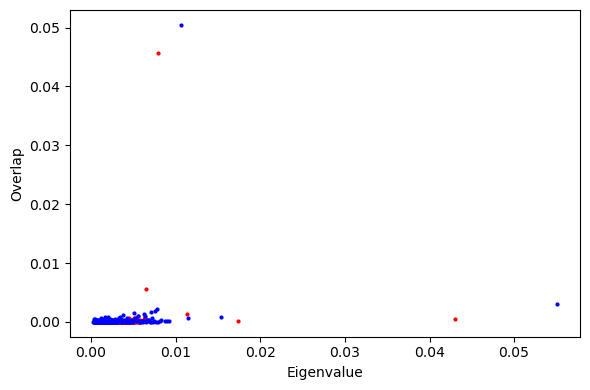

Participation ratio ampar=0.63: 105.96024512742481
Participation ratio ampar=1.0: 72.90699958993505
participation ratio FR/CTR: 1.4533617584511436
Mean_Eigval_Ratio FR/CTR: 1.0500708300857093


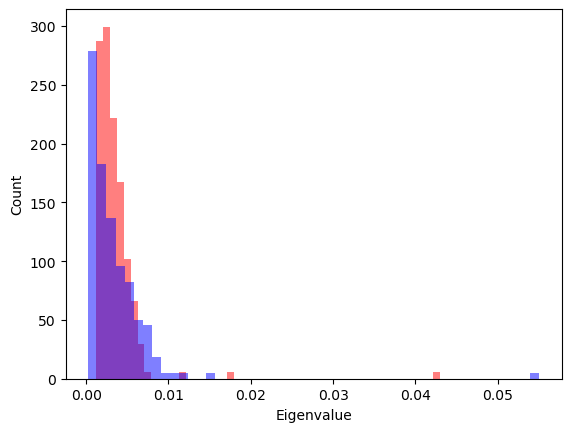

In [99]:
# TEST FR VS CTR

fig, ax = plt.subplots(figsize=(6, 4))
size = 50
k_val = 0
angle_2 = 0.51
sig_temp = 0.0
sig_eta = 0.1
mean_evals1, mean_overlap1, xfit, yfit, a, b,snr_1og, dmu1 = overlap_function(
    tensors, ampar=0.63, rin=1.22, sigma_temp=sig_temp,sigma_eta=sig_eta,  idir1=0.5, idir2=angle_2, k=k_val, window_size=size
)
ax.plot(mean_evals1, mean_overlap1, 'o', markersize=2, color="red")
# ax.plot(xfit, yfit, "-", color="blue", lw=2)
snr_1 = np.sum(mean_overlap1/mean_evals1)

mean_evals2, mean_overlap2, xfit, yfit, a, b, snr_2og, dmu2 = overlap_function(
    tensors, ampar=1, rin=1, sigma_temp=sig_temp,sigma_eta=sig_eta,  idir1=0.5, idir2=angle_2,k=k_val, window_size=size
)
ax.plot(mean_evals2, mean_overlap2, 'o', markersize=2, color="blue")
# ax.plot(xfit, yfit, "-", color="red", lw=2)

ax.set_xlabel("Eigenvalue")
ax.set_ylabel("Overlap")
fig.tight_layout()
snr_2 = np.sum(mean_overlap2/mean_evals2)
# print(snr_1/snr_2)
print(snr_1og/snr_2og)
print("Dmu norm ampar=0.63:", np.linalg.norm(dmu1))
print("Dmu norm ampar=1.0:", np.linalg.norm(dmu2))
plt.show()
plt.hist(mean_evals1, bins=50, color="red", alpha=0.5, label="ampar=0.63", density=True)
plt.hist(mean_evals2, bins=50, color="blue", alpha=0.5, label="ampar=1.0", density=True)
plt.xlabel("Eigenvalue")
plt.ylabel("Count")
participation_ratio1 = (np.sum(mean_evals1))**2/np.sum(mean_evals1**2)
participation_ratio2 = (np.sum(mean_evals2))**2/np.sum(mean_evals2**2)
print("Participation ratio ampar=0.63:", participation_ratio1)
print("Participation ratio ampar=1.0:", participation_ratio2)   
print('participation ratio FR/CTR:', participation_ratio1/participation_ratio2)
print('Mean_Eigval_Ratio FR/CTR:', np.mean(mean_evals1)/np.mean(mean_evals2))

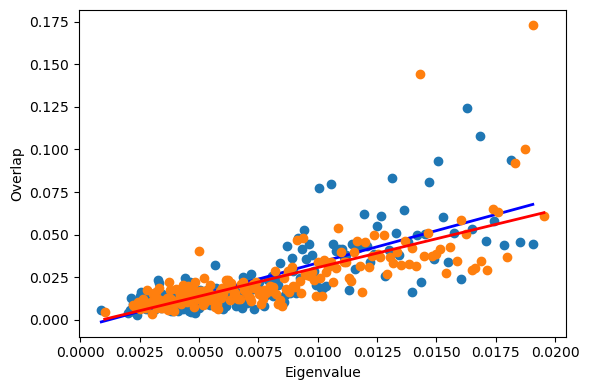

In [5]:
# AMPAR_VALUES: List[float] = [1.0,0.63]
# RIN_VALUES: List[float] = [1.0, 1.22]
# ETA_VALUES: List[float] = [0.0, 0.1]
# TEMP_VALUES: List[float] = [0.0, 0.01]

# Plot Overlap vs Eigenvalues
## For each ampar, rin, sigma_eta, sigma_temp AND IDIR combination
fig, ax = plt.subplots(figsize=(6, 4))

mean_evals, mean_overlap, xfit, yfit, a, b = overlap_function(
    tensors, ampar=1.0, rin=1.0, sigma_temp=0.0,sigma_eta=0.1,  idir1=0.5, idir2=0.8
)
ax.plot(mean_evals, mean_overlap, "o")
ax.plot(xfit, yfit, "-", color="blue", lw=2)

mean_evals, mean_overlap, xfit, yfit, a, b = overlap_function(
    tensors, ampar=0.63, rin=1.22, sigma_temp=0.0,sigma_eta=0.1,  idir1=0.5, idir2=0.8
)
ax.plot(mean_evals, mean_overlap, "o")
ax.plot(xfit, yfit, "-", color="red", lw=2)

ax.set_xlabel("Eigenvalue")
ax.set_ylabel("Overlap")
fig.tight_layout()

In [6]:
idir_delta_ctr_et_sig, snr_ctr_et_sig, error_ctr_et_sig = snr_delta_function(tensors, ampar=1.0, rin=1.0, sigma_eta=0.1, sigma_temp=0.1)
idir_delta_fr_et_sig, snr_fr_et_sig, error_fr_et_sig = snr_delta_function(tensors, ampar=0.63, rin=1.22, sigma_eta=0.1, sigma_temp=0.1)

idir_delta_ctr_et, snr_ctr_et, error_ctr_et = snr_delta_function(tensors, ampar=1.0, rin=1.0, sigma_eta=0.01, sigma_temp=0.0)
idir_delta_fr_et, snr_fr_et, error_fr_et = snr_delta_function(tensors, ampar=0.63, rin=1.22, sigma_eta=0.01, sigma_temp=0.0)

idir_delta_ctr_et2, snr_ctr_et2, error_ctr_et2 = snr_delta_function(tensors, ampar=1.0, rin=1.0, sigma_eta=0.1, sigma_temp=0.0)
idir_delta_fr_et2, snr_fr_et2, error_fr_et2 = snr_delta_function(tensors, ampar=0.63, rin=1.22, sigma_eta=0.1, sigma_temp=0.0)

idir_delta_ctr_sig, snr_ctr_sig, error_ctr_sig = snr_delta_function(tensors, ampar=1.0, rin=1.0, sigma_eta=0.0, sigma_temp=0.01)
idir_delta_fr_sig, snr_fr_sig, error_fr_sig = snr_delta_function(tensors, ampar=0.63, rin=1.22, sigma_eta=0.0, sigma_temp=0.01)

idir_delta_ctr_sig2, snr_ctr_sig2, error_ctr_sig2 = snr_delta_function(tensors, ampar=1.0, rin=1.0, sigma_eta=0.0, sigma_temp=0.1)
idir_delta_fr_sig2, snr_fr_sig2, error_fr_sig2 = snr_delta_function(tensors, ampar=0.63, rin=1.22, sigma_eta=0.0, sigma_temp=0.1)

In [19]:
def get_run(ampar, rin, sigma_eta, sigma_temp):
    rec = results[(ampar, rin, sigma_eta, sigma_temp)]
    return rec["idir_delta"], rec["snr"], rec["err"]
import os
import pickle
from itertools import product


CACHE_FILE = "snr_grid_results.pkl"

if os.path.exists(CACHE_FILE):
    print("Loading cached results...")
    with open(CACHE_FILE, "rb") as f:
        data = pickle.load(f)
    AMPAR_VALUES = data["AMPAR_VALUES"]
    RIN_VALUES   = data["RIN_VALUES"]
    ETA_VALUES   = data["ETA_VALUES"]
    TEMP_VALUES  = data["TEMP_VALUES"]
    results      = data["results"]
else:
    print("Computing results from scratch...")
    from itertools import product

    results = {}
    for ampar, rin, sigma_eta, sigma_temp in product(
        AMPAR_VALUES, RIN_VALUES, ETA_VALUES, TEMP_VALUES
    ):
        key = (ampar, rin, sigma_eta, sigma_temp)
        print("Computing", key)

        idir_delta, snr, err = snr_delta_function(
            tensors,
            ampar=ampar,
            rin=rin,
            sigma_eta=sigma_eta,
            sigma_temp=sigma_temp,
        )

        results[key] = dict(
            idir_delta=idir_delta,
            snr=snr,
            err=err,
        )

    with open(CACHE_FILE, "wb") as f:
        pickle.dump(
            dict(
                AMPAR_VALUES=AMPAR_VALUES,
                RIN_VALUES=RIN_VALUES,
                ETA_VALUES=ETA_VALUES,
                TEMP_VALUES=TEMP_VALUES,
                results=results,
            ),
            f,
        )
    print("Saved results to", CACHE_FILE)

Computing results from scratch...
Computing (1.0, 1.0, 0.0, 0.0)
Computing (1.0, 1.0, 0.0, 0.01)
Computing (1.0, 1.0, 0.0, 0.1)
Computing (1.0, 1.0, 0.01, 0.0)
Computing (1.0, 1.0, 0.01, 0.01)
Computing (1.0, 1.0, 0.01, 0.1)
Computing (1.0, 1.0, 0.1, 0.0)
Computing (1.0, 1.0, 0.1, 0.01)
Computing (1.0, 1.0, 0.1, 0.1)
Computing (1.0, 1.22, 0.0, 0.0)
Computing (1.0, 1.22, 0.0, 0.01)
Computing (1.0, 1.22, 0.0, 0.1)
Computing (1.0, 1.22, 0.01, 0.0)
Computing (1.0, 1.22, 0.01, 0.01)
Computing (1.0, 1.22, 0.01, 0.1)
Computing (1.0, 1.22, 0.1, 0.0)
Computing (1.0, 1.22, 0.1, 0.01)
Computing (1.0, 1.22, 0.1, 0.1)
Computing (0.63, 1.0, 0.0, 0.0)
Computing (0.63, 1.0, 0.0, 0.01)
Computing (0.63, 1.0, 0.0, 0.1)
Computing (0.63, 1.0, 0.01, 0.0)
Computing (0.63, 1.0, 0.01, 0.01)
Computing (0.63, 1.0, 0.01, 0.1)
Computing (0.63, 1.0, 0.1, 0.0)
Computing (0.63, 1.0, 0.1, 0.01)
Computing (0.63, 1.0, 0.1, 0.1)
Computing (0.63, 1.22, 0.0, 0.0)
Computing (0.63, 1.22, 0.0, 0.01)
Computing (0.63, 1.22, 0.0

In [20]:
import numpy as np
from scipy.stats import norm

def snr_to_perf_and_err(snr, snr_err):
    """
    Convert an SNR value and its error into performance and propagated error.
    SNR error is std of SNR, not variance.
    """
    dprime = np.sqrt(snr)
    z = dprime / np.sqrt(2)
    perf = norm.cdf(z)

    pdf = norm.pdf(z)
    dP_dSNR = pdf * (1 / (2 * np.sqrt(2 * snr)))  # derivative

    perf_err = np.abs(dP_dSNR) * snr_err

    return perf, perf_err


def get_curve(ampar, rin, sigma_eta, sigma_temp, metric="perf"):
    """
    Fetch x, y, yerr for a given parameter combo.
    metric: 'perf' (performance) or 'snr'
    """
    rec = results[(ampar, rin, sigma_eta, sigma_temp)]
    x = rec["idir_delta"]
    snr = rec["snr"]
    snr_err = rec["err"]

    if metric == "perf":
        y, yerr = snr_to_perf_and_err(snr, snr_err)
        y_label = "Performance"
    elif metric == "snr":
        y, yerr = snr, snr_err
        y_label = "SNR"
    else:
        raise ValueError(f"Unknown metric {metric!r}")

    return x, y, yerr, y_label


In [23]:
import plotly.graph_objects as go
import ipywidgets as widgets

# -------- defaults for each trace --------
trace1_defaults = dict(ampar=1.0,  rin=1.0,  sigma_eta=0.1, sigma_temp=0.1)
trace2_defaults = dict(ampar=0.63, rin=1.22, sigma_eta=0.1, sigma_temp=0.1)

DEFAULT_METRIC = "perf"  # 'perf' or 'snr'


# -------- initial data for both traces --------
x1, y1, yerr1, y_label1 = get_curve(metric=DEFAULT_METRIC, **trace1_defaults)
x2, y2, yerr2, _        = get_curve(metric=DEFAULT_METRIC, **trace2_defaults)

fig = go.FigureWidget(
    data=[
        go.Scatter(
            x=x1,
            y=y1,
            mode="markers+lines",
            error_y=dict(
                type="data",
                array=yerr1,
                visible=True,
                thickness=1.5,
                width=4,
            ),
            name="Trace 1",
        ),
        go.Scatter(
            x=x2,
            y=y2,
            mode="markers+lines",
            error_y=dict(
                type="data",
                array=yerr2,
                visible=True,
                thickness=1.5,
                width=4,
            ),
            name="Trace 2",
        ),
    ],
    layout=go.Layout(
        title=("Trace 1: ampar={ampar1}, rin={rin1}, σ_eta={eta1}, σ_temp={temp1} | "
               "Trace 2: ampar={ampar2}, rin={rin2}, σ_eta={eta2}, σ_temp={temp2}"
               " — {y_label}").format(
            ampar1=trace1_defaults["ampar"],
            rin1=trace1_defaults["rin"],
            eta1=trace1_defaults["sigma_eta"],
            temp1=trace1_defaults["sigma_temp"],
            ampar2=trace2_defaults["ampar"],
            rin2=trace2_defaults["rin"],
            eta2=trace2_defaults["sigma_eta"],
            temp2=trace2_defaults["sigma_temp"],
            y_label=y_label1,
        ),
        xaxis_title="idir_delta",
        yaxis_title=y_label1,
        template="plotly_white",
    ),
)

# -------- widgets for Trace 1 --------
t1_ampar = widgets.ToggleButtons(
    options=[(str(v), v) for v in AMPAR_VALUES],
    description="ampar 1:",
    value=trace1_defaults["ampar"],
)
t1_rin = widgets.ToggleButtons(
    options=[(str(v), v) for v in RIN_VALUES],
    description="rin 1:",
    value=trace1_defaults["rin"],
)
t1_eta = widgets.ToggleButtons(
    options=[(str(v), v) for v in ETA_VALUES],
    description="σ_eta 1:",
    value=trace1_defaults["sigma_eta"],
)
t1_temp = widgets.ToggleButtons(
    options=[(str(v), v) for v in TEMP_VALUES],
    description="σ_temp 1:",
    value=trace1_defaults["sigma_temp"],
)

# -------- widgets for Trace 2 --------
t2_ampar = widgets.ToggleButtons(
    options=[(str(v), v) for v in AMPAR_VALUES],
    description="ampar 2:",
    value=trace2_defaults["ampar"],
)
t2_rin = widgets.ToggleButtons(
    options=[(str(v), v) for v in RIN_VALUES],
    description="rin 2:",
    value=trace2_defaults["rin"],
)
t2_eta = widgets.ToggleButtons(
    options=[(str(v), v) for v in ETA_VALUES],
    description="σ_eta 2:",
    value=trace2_defaults["sigma_eta"],
)
t2_temp = widgets.ToggleButtons(
    options=[(str(v), v) for v in TEMP_VALUES],
    description="σ_temp 2:",
    value=trace2_defaults["sigma_temp"],
)

# -------- global metric toggle --------
metric_widget = widgets.ToggleButtons(
    options=[("Performance", "perf"), ("SNR", "snr")],
    description="y-axis:",
    value=DEFAULT_METRIC,
)

# -------- callback to update figure when anything changes --------
def update_plot(change=None):
    # read current widget values
    p1 = dict(
        ampar=t1_ampar.value,
        rin=t1_rin.value,
        sigma_eta=t1_eta.value,
        sigma_temp=t1_temp.value,
    )
    p2 = dict(
        ampar=t2_ampar.value,
        rin=t2_rin.value,
        sigma_eta=t2_eta.value,
        sigma_temp=t2_temp.value,
    )
    metric = metric_widget.value

    x1, y1, yerr1, y_label = get_curve(metric=metric, **p1)
    x2, y2, yerr2, _       = get_curve(metric=metric, **p2)

    with fig.batch_update():
        # update trace 1
        fig.data[0].x = x1
        fig.data[0].y = y1
        fig.data[0].error_y.array = yerr1

        # update trace 2
        fig.data[1].x = x2
        fig.data[1].y = y2
        fig.data[1].error_y.array = yerr2

        # labels / title
        fig.layout.yaxis.title = y_label
        fig.layout.title = (
            f"Trace 1: ampar={p1['ampar']}, rin={p1['rin']}, "
            f"σ_eta={p1['sigma_eta']}, σ_temp={p1['sigma_temp']} | "
            f"Trace 2: ampar={p2['ampar']}, rin={p2['rin']}, "
            f"σ_eta={p2['sigma_eta']}, σ_temp={p2['sigma_temp']} — {y_label}"
        )

# attach callback
for w in [
    t1_ampar, t1_rin, t1_eta, t1_temp,
    t2_ampar, t2_rin, t2_eta, t2_temp,
    metric_widget,
]:
    w.observe(update_plot, names="value")

# layout widgets
trace1_box = widgets.VBox([widgets.HTML("<b>Trace 1</b>"),
                           t1_ampar, t1_rin, t1_eta, t1_temp])
trace2_box = widgets.VBox([widgets.HTML("<b>Trace 2</b>"),
                           t2_ampar, t2_rin, t2_eta, t2_temp])
metric_box = widgets.VBox([widgets.HTML("<b>Metric</b>"),
                           metric_widget])

controls = widgets.HBox([trace1_box, trace2_box, metric_box])

display(controls, fig)


FigureWidget({
    'data': [{'error_y': {'array': {'bdata': ('IPmo131mUT+7c6em+PJKP1d7lPQBvV' ... 'drm7Q++60b3C5LuT43cSBnxsK6Pg=='),
                                    'dtype': 'f8'},
                          'thickness': 1.5,
                          'type': 'data',
                          'visible': True,
                          'width': 4},
              'mode': 'markers+lines',
              'name': 'Trace 1',
              'type': 'scatter',
              'uid': 'a14868ef-fa35-44da-a23d-1b25120438c9',
              'x': {'bdata': ('gBSuR+F6dD+AFK5H4XqEP8AehetRuI' ... 'hcj9I/4noUrkfh0j80MzMzMzPTPw=='),
                    'dtype': 'f8'},
              'y': {'bdata': ('ERyB/8i+5D8hRKVn8TPmP/5ACLdrAO' ... 'mt/+8/B6fo4qz/7z9HHFIUrP/vPw=='),
                    'dtype': 'f8'}},
             {'error_y': {'array': {'bdata': ('Em/jySe/Uz/4K1mbSnhPP6Ks4MSa4V' ... 'hgSog+nocPceuHhz7yU7h8iVqJPg=='),
                                    'dtype': 'f8'},
                          'thickne

In [24]:
for sigma_eta, sigma_temp in [(0.1, 0.1), (0.01, 0.0), (0.1, 0.0)]:
    x_c, snr_c, err_c, _ = get_curve(1.0, 1.0, sigma_eta, sigma_temp, metric="snr")
    x_f, snr_f, err_f, _ = get_curve(0.63, 1.22, sigma_eta, sigma_temp, metric="snr")

    print(f"\nCondition σ_eta={sigma_eta}, σ_temp={sigma_temp}")
    print("Control (1.0, 1.0): mean SNR =", snr_c.mean())
    print("FR     (0.63,1.22): mean SNR =", snr_f.mean())



Condition σ_eta=0.1, σ_temp=0.1
Control (1.0, 1.0): mean SNR = 18.42491728006356
FR     (0.63,1.22): mean SNR = 24.182609275064017

Condition σ_eta=0.01, σ_temp=0.0
Control (1.0, 1.0): mean SNR = 30311415453569.516
FR     (0.63,1.22): mean SNR = 28145241378289.574

Condition σ_eta=0.1, σ_temp=0.0
Control (1.0, 1.0): mean SNR = 89.0972644412302
FR     (0.63,1.22): mean SNR = 79.6876556219533


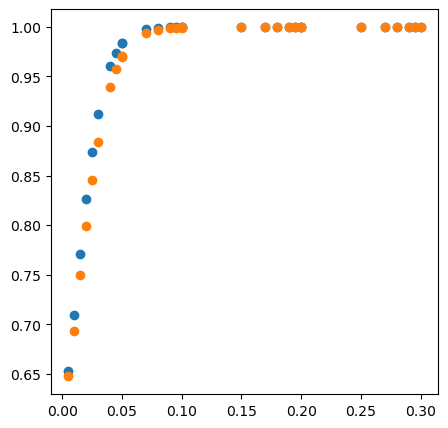

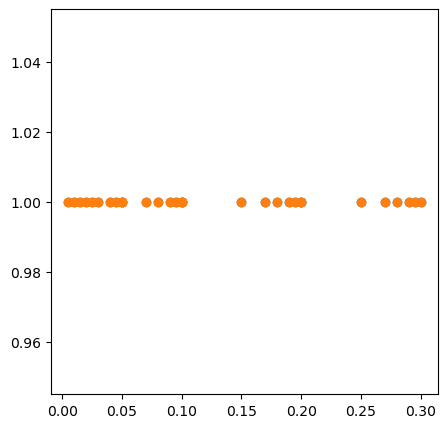

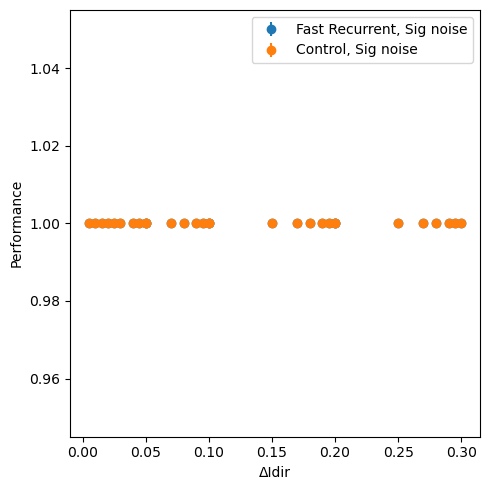

In [10]:
from scipy.stats import norm


# # Plot SNR vs Delta Idir
# ## For each ampar, rin, sigma_eta, sigma_temp combination



def snr_to_perf_and_err(snr, snr_err):
    """
    Convert an SNR value and its error into performance and propagated error.
    SNR error is std of SNR, not variance.
    """
    # Compute d' and performance
    dprime = np.sqrt(snr)
    z = dprime / np.sqrt(2)
    perf = norm.cdf(z)

    # PDF at z
    pdf = norm.pdf(z)

    # derivative dP/dSNR
    dP_dSNR = pdf * (1 / (2 * np.sqrt(2 * snr)))

    # propagated error
    perf_err = np.abs(dP_dSNR) * snr_err

    return perf, perf_err # returns the performance
    # return snr, snr_err # returns the snr


# #Figure 1
# fig, ax = plt.subplots(figsize=(5, 5))
# ax.errorbar(idir_delta_fr_et_sig, snr_to_perf_and_err(snr_fr_et_sig, error_fr_et_sig)[0], yerr=snr_to_perf_and_err(snr_fr_et_sig, error_fr_et_sig)[1], fmt='o', label='Fast Recurrent, ET noise')
# ax.errorbar(idir_delta_ctr_et_sig, snr_to_perf_and_err(snr_ctr_et_sig, error_ctr_et_sig)[0], yerr=snr_to_perf_and_err(snr_ctr_et_sig, error_ctr_et_sig)[1], fmt='o', label='Control, ET noise')

# # Figure 2
# fig, ax = plt.subplots(figsize=(5, 5))
# ax.errorbar(idir_delta_fr_et, snr_to_perf_and_err(snr_fr_et, error_fr_et)[0], yerr=snr_to_perf_and_err(snr_fr_et, error_fr_et)[1], fmt='o', label='Fast Recurrent, ET noise')
# ax.errorbar(idir_delta_ctr_et, snr_to_perf_and_err(snr_ctr_et, error_ctr_et)[0], yerr=snr_to_perf_and_err(snr_ctr_et, error_ctr_et)[1], fmt='o', label='Control, ET noise')

# # Figure 3
# fig, ax = plt.subplots(figsize=(5, 5))
# ax.errorbar(idir_delta_fr_sig, snr_to_perf_and_err(snr_fr_sig, error_fr_sig)[0], yerr=snr_to_perf_and_err(snr_fr_sig, error_fr_sig)[1], fmt='o', label='Fast Recurrent, Sig noise')
# ax.errorbar(idir_delta_ctr_sig, snr_to_perf_and_err(snr_ctr_sig, error_ctr_sig)[0], yerr= snr_to_perf_and_err(snr_ctr_sig, error_ctr_sig)[1], fmt='o', label='Control, Sig noise')

# ax.set_xlabel("ΔIdir")
# ax.set_ylabel("Performance")
# ax.legend()
# fig.tight_layout()



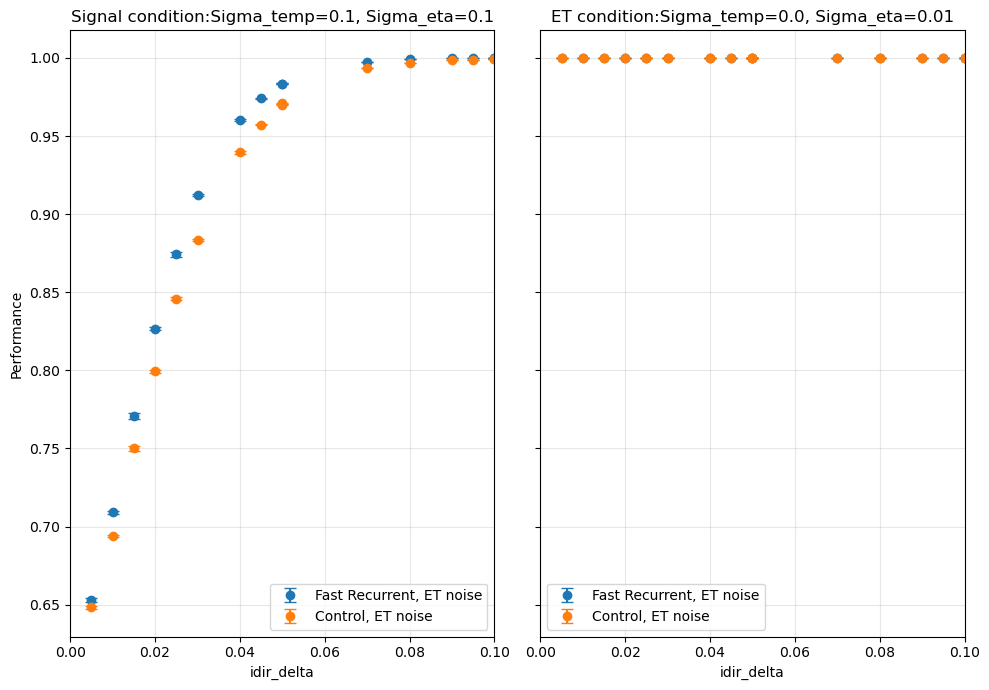

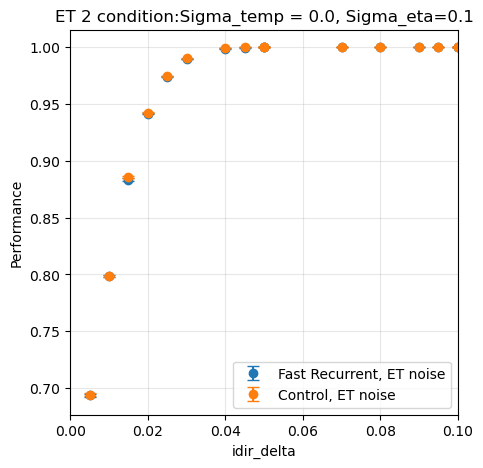

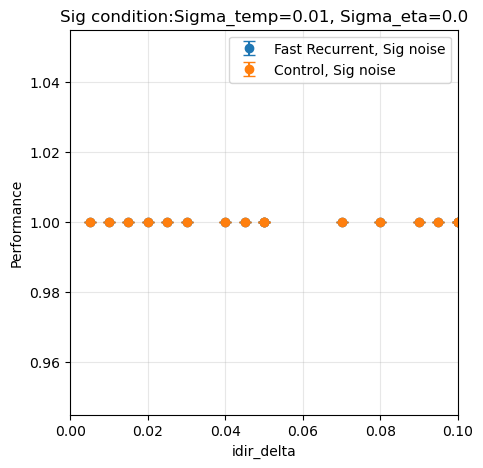

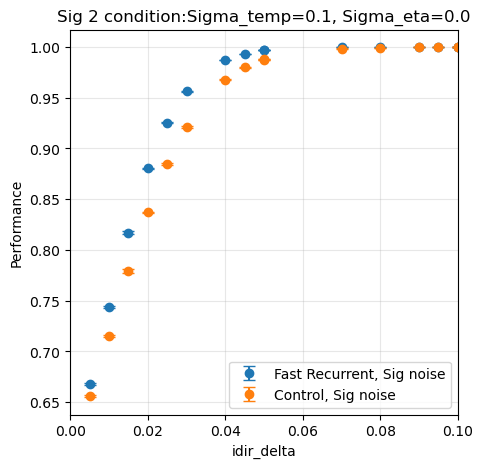

In [14]:
import matplotlib.pyplot as plt

def plot_perf(ax, idir_delta, snr, err, label, color):
    perf, perf_err = snr_to_perf_and_err(snr, err)
    ax.errorbar(
        idir_delta,
        perf,
        yerr=perf_err,
        fmt='o',
        ms=6,
        lw=1.5,
        capsize=4,
        label=label,
        color=color,
    )
    ax.set_xlim(0, 0.1)

fig, axes = plt.subplots(1, 2, figsize=(10, 7), sharey=True, tight_layout=True)

# Figure 1
plot_perf(
    axes[0],
    idir_delta_fr_et_sig,
    snr_fr_et_sig,
    error_fr_et_sig,
    'Fast Recurrent, ET noise',
    '#1f77b4',
)
plot_perf(
    axes[0],
    idir_delta_ctr_et_sig,
    snr_ctr_et_sig,
    error_ctr_et_sig,
    'Control, ET noise',
    '#ff7f0e',
)
axes[0].set_title('Signal condition:Sigma_temp=0.1, Sigma_eta=0.1')
axes[0].set_xlabel('idir_delta')
axes[0].set_ylabel('Performance')
axes[0].grid(True, alpha=0.3)
# axes[0].set_xlim(0,0.06)
axes[0].legend()

# Figure 2
plot_perf(
    axes[1],
    idir_delta_fr_et,
    snr_fr_et,
    error_fr_et,
    'Fast Recurrent, ET noise',
    '#1f77b4',
)
plot_perf(
    axes[1],
    idir_delta_ctr_et,
    snr_ctr_et,
    error_ctr_et,
    'Control, ET noise',
    '#ff7f0e',
)
axes[1].set_title('ET condition:Sigma_temp=0.0, Sigma_eta=0.01')
axes[1].set_xlabel('idir_delta')
axes[1].grid(True, alpha=0.3)
axes[1].legend()
# axes[1].set_xlim(0,0.06)

# Figure 3
fig, ax = plt.subplots(figsize=(5, 5))
plot_perf(
    ax,
    idir_delta_fr_et2,
    snr_fr_et2,
    error_fr_et2,
    'Fast Recurrent, ET noise',
    '#1f77b4',
)
plot_perf(
    ax,
    idir_delta_ctr_et2,
    snr_ctr_et2,
    error_ctr_et2,
    'Control, ET noise',
    '#ff7f0e',
)
ax.set_title('ET 2 condition:Sigma_temp = 0.0, Sigma_eta=0.1')
ax.set_xlabel('idir_delta')
ax.set_ylabel('Performance')
ax.grid(True, alpha=0.3)
ax.legend()


# Figure 4
fig, ax = plt.subplots(figsize=(5, 5))
plot_perf(
    ax,
    idir_delta_fr_sig,
    snr_fr_sig,
    error_fr_sig,
    'Fast Recurrent, Sig noise',
    '#1f77b4',
)
plot_perf(
    ax,
    idir_delta_ctr_sig,
    snr_ctr_sig,
    error_ctr_sig,
    'Control, Sig noise',
    '#ff7f0e',
)
ax.set_xlabel('idir_delta')
ax.set_ylabel('Performance')
ax.set_title('Sig condition:Sigma_temp=0.01, Sigma_eta=0.0')
ax.grid(True, alpha=0.3)
ax.legend()

# Figure 4
fig, ax = plt.subplots(figsize=(5, 5))
plot_perf(
    ax,
    idir_delta_fr_sig2,
    snr_fr_sig2,
    error_fr_sig2,
    'Fast Recurrent, Sig noise',
    '#1f77b4',
)
plot_perf(
    ax,
    idir_delta_ctr_sig2,
    snr_ctr_sig2,
    error_ctr_sig2,
    'Control, Sig noise',
    '#ff7f0e',
)
ax.set_xlabel('idir_delta')
ax.set_ylabel('Performance')
ax.set_title('Sig 2 condition:Sigma_temp=0.1, Sigma_eta=0.0')
ax.grid(True, alpha=0.3)
ax.legend()


In [15]:
import plotly.graph_objects as go

# assumes you already have:
#   snr_to_perf_and_err(...)
#   idir_delta_fr_et_sig, snr_fr_et_sig, error_fr_et_sig, ...
#   etc. for all the arrays you used in your Matplotlib code


def make_perf_trace(idir_delta, snr, err, name, showlegend=True):
    """Helper to create a Plotly scatter with error bars from SNR data."""
    perf, perf_err = snr_to_perf_and_err(snr, err)
    return go.Scatter(
        x=idir_delta,
        y=perf,
        mode="markers+lines",
        name=name,
        error_y=dict(
            type="data",
            array=perf_err,
            visible=True,
            thickness=1.5,
            width=4,
        ),
        marker=dict(size=6),
        showlegend=showlegend,
    )


fig = go.Figure()

# --- Add all traces (FR + Control) for each condition ------------------------

# 0–1: Signal condition: Sigma_temp=0.1, Sigma_eta=0.1
fig.add_trace(
    make_perf_trace(
        idir_delta_fr_et_sig,
        snr_fr_et_sig,
        error_fr_et_sig,
        "Fast Recurrent – Signal (σ_temp=0.1, σ_η=0.1)",
    )
)
fig.add_trace(
    make_perf_trace(
        idir_delta_ctr_et_sig,
        snr_ctr_et_sig,
        error_ctr_et_sig,
        "Control – Signal (σ_temp=0.1, σ_η=0.1)",
    )
)

# 2–3: ET condition: Sigma_temp=0.0, Sigma_eta=0.01
fig.add_trace(
    make_perf_trace(
        idir_delta_fr_et,
        snr_fr_et,
        error_fr_et,
        "Fast Recurrent – ET (σ_temp=0.0, σ_η=0.01)",
    )
)
fig.add_trace(
    make_perf_trace(
        idir_delta_ctr_et,
        snr_ctr_et,
        error_ctr_et,
        "Control – ET (σ_temp=0.0, σ_η=0.01)",
    )
)

# 4–5: ET 2 condition: Sigma_temp=0.0, Sigma_eta=0.1
fig.add_trace(
    make_perf_trace(
        idir_delta_fr_et2,
        snr_fr_et2,
        error_fr_et2,
        "Fast Recurrent – ET2 (σ_temp=0.0, σ_η=0.1)",
    )
)
fig.add_trace(
    make_perf_trace(
        idir_delta_ctr_et2,
        snr_ctr_et2,
        error_ctr_et2,
        "Control – ET2 (σ_temp=0.0, σ_η=0.1)",
    )
)

# 6–7: Sig condition: Sigma_temp=0.01, Sigma_eta=0.0
fig.add_trace(
    make_perf_trace(
        idir_delta_fr_sig,
        snr_fr_sig,
        error_fr_sig,
        "Fast Recurrent – Sig (σ_temp=0.01, σ_η=0.0)",
    )
)
fig.add_trace(
    make_perf_trace(
        idir_delta_ctr_sig,
        snr_ctr_sig,
        error_ctr_sig,
        "Control – Sig (σ_temp=0.01, σ_η=0.0)",
    )
)

# 8–9: Sig 2 condition: Sigma_temp=0.1, Sigma_eta=0.0
fig.add_trace(
    make_perf_trace(
        idir_delta_fr_sig2,
        snr_fr_sig2,
        error_fr_sig2,
        "Fast Recurrent – Sig2 (σ_temp=0.1, σ_η=0.0)",
    )
)
fig.add_trace(
    make_perf_trace(
        idir_delta_ctr_sig2,
        snr_ctr_sig2,
        error_ctr_sig2,
        "Control – Sig2 (σ_temp=0.1, σ_η=0.0)",
    )
)

# --- Visibility masks for each condition (button toggles) -------------------
# Each list has length 10 (one bool per trace above).
visible_signal  = [ True,  True, False, False, False, False, False, False, False, False]
visible_et      = [False, False,  True,  True, False, False, False, False, False, False]
visible_et2     = [False, False, False, False,  True,  True, False, False, False, False]
visible_sig     = [False, False, False, False, False, False,  True,  True, False, False]
visible_sig2    = [False, False, False, False, False, False, False, False,  True,  True]

buttons = [
    dict(
        label="Signal: σ_temp=0.1, σ_η=0.1",
        method="update",
        args=[
            {"visible": visible_signal},
            {
                "title": "Signal condition: σ_temp=0.1, σ_η=0.1",
            },
        ],
    ),
    dict(
        label="ET: σ_temp=0.0, σ_η=0.01",
        method="update",
        args=[
            {"visible": visible_et},
            {
                "title": "ET condition: σ_temp=0.0, σ_η=0.01",
            },
        ],
    ),
    dict(
        label="ET2: σ_temp=0.0, σ_η=0.1",
        method="update",
        args=[
            {"visible": visible_et2},
            {
                "title": "ET2 condition: σ_temp=0.0, σ_η=0.1",
            },
        ],
    ),
    dict(
        label="Sig: σ_temp=0.01, σ_η=0.0",
        method="update",
        args=[
            {"visible": visible_sig},
            {
                "title": "Sig condition: σ_temp=0.01, σ_η=0.0",
            },
        ],
    ),
    dict(
        label="Sig2: σ_temp=0.1, σ_η=0.0",
        method="update",
        args=[
            {"visible": visible_sig2},
            {
                "title": "Sig2 condition: σ_temp=0.1, σ_η=0.0",
            },
        ],
    ),
]

# Start by showing the first condition (Signal)
fig.update_traces(visible=False)
for i, vis in enumerate(visible_signal):
    fig.data[i].visible = vis

fig.update_layout(
    xaxis_title="idir_delta",
    yaxis_title="Performance",
    title="Signal condition: σ_temp=0.1, σ_η=0.1",
    template="plotly_white",
    updatemenus=[
        dict(
            type="buttons",
            direction="right",
            x=0.5,
            y=1.15,
            showactive=True,
            buttons=buttons,
        )
    ],
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1.0,
    ),
)

fig.show()


In [1]:
from scipy.stats import norm
def compute_snrs(
    state: np.ndarray,
    idir_1: float,
    idir_2: float,
    ) -> Tuple[np.ndarray, np.ndarray]:
    """
    Compute per-trial/per-angle SNR and eigenvalues.
    state shape: (neurons, generations, trials, idir)
    idir_values: iterable of idir values aligned with the last dim of `state`.
    Returns:
      snr_per_mode: trials × neurons × idir
      evals_per_mode: trials × neurons × idir
    """
    neurons, _, trials, idirs = state.shape
    state = state.reshape((neurons, -1, idirs))
    angle =  np.flatnonzero(np.isclose(IDIR_VALUES, idir_1))[0]
    other_angle = np.flatnonzero(np.isclose(IDIR_VALUES, idir_2))[0]
    delta_mu = state[:, :, angle].mean(axis=1) - state[:, :, other_angle].mean(axis=1)
    covariance = np.cov(state[:, :, angle])

    snr_1= delta_mu.T @ np.linalg.pinv(covariance) @ delta_mu


    return snr_1

def compute_snr_per_delta(state: np.ndarray, idir_values: np.ndarray, window_size: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    state: (neurons, generations, trials, idir)
    idir_values: array-like of length idir
    Returns:
        deltas: (num_pairs * trials,) absolute ΔIdir for each trial/pair
        snr:    (num_pairs * trials,) δ^T C^{-1} δ for each trial/pair
    """
    neurons, _, trials, idirs = state.shape
    if len(idir_values) != idirs:
        raise ValueError("len(idir_values) must match state.shape[3]")
    average_size = window_size
    n_neurons, n_generations, n_trials, n_idir = state.shape
    n_blocks = n_generations // average_size  # integer division
    cut = n_blocks * average_size             # how many generations to keep

    data_trimmed = state[:, :cut, :, :]
    data_reshaped = data_trimmed.reshape(n_neurons, n_blocks, average_size, n_trials, n_idir)
    data_avg = data_reshaped.mean(axis=2)

    deltas, snrs = [], []

    # use combinations to avoid duplicate (i, j) vs (j, i); include both if you prefer symmetry
    # for idir_i, idir_j in combinations(range(idirs), 2):
    #     delta_idir = abs(idir_values[idir_i] - idir_values[idir_j])
    #     deltas.append(delta_idir)
    #     snrs.append(compute_snrs(data_avg, idir_1=idir_values[idir_i], idir_2=idir_values[idir_j]))

    idir_i = 0.5
    for idir_j in range(idirs):
        if np.isclose(idir_values[idir_j], idir_i):
            continue
        delta_idir = abs(idir_values[idir_j] - idir_i)
        deltas.append(delta_idir)
        snrs.append(compute_snrs(data_avg, idir_1=idir_i, idir_2=idir_values[idir_j]))

    return np.asarray(deltas), np.asarray(snrs)

temp = 0.01
window = 20

def snr_to_performance(snrval):
    dprime = np.sqrt(snrval)
    z = dprime / np.sqrt(2)
    perf = norm.cdf(z)
    return perf
    # return snrval

delta_vals, snr_vals = compute_snr_per_delta(tensors[1,1,temp,0.1], IDIR_VALUES, window_size=window)
sorted_delta_vals1 = np.sort(delta_vals)
sorted_snr_vals1 = snr_vals[np.argsort(delta_vals)]

plt.plot(sorted_delta_vals1, snr_to_performance(sorted_snr_vals1), 'o-',color = 'blue', markersize = 4)
delta_vals, snr_vals = compute_snr_per_delta(tensors[.63,1.22,temp,0.1], IDIR_VALUES, window_size=window)
sorted_delta_vals2 = np.sort(delta_vals)
sorted_snr_vals2 = snr_vals[np.argsort(delta_vals)]
plt.plot(sorted_delta_vals2, snr_to_performance(sorted_snr_vals2),'o-', color = 'red', markersize = 4)

plt.show()
plt.plot(sorted_delta_vals2, sorted_snr_vals2/sorted_snr_vals1, 'o-', color = 'green', markersize = 4)

# plt.xlim(0,0.023)
# plt.ylim(0.5,.9)

NameError: name 'np' is not defined

Text(0, 0.5, 'Delta X vector')

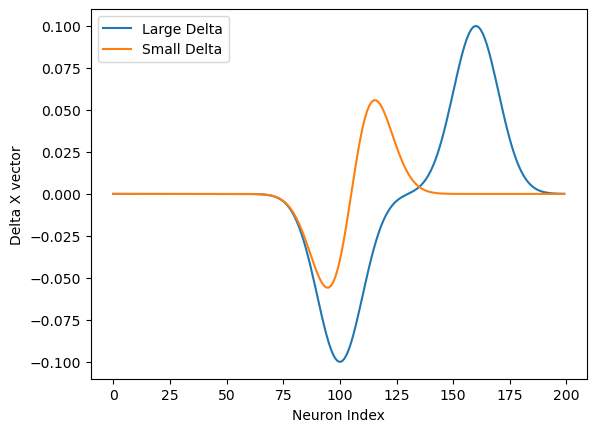

In [111]:
Idir = 0.5
N = 200
Sig_input = 0.05
AMP = 0.1
delta = .005


def get_bump(idir, num_neurons, sigma_input, amplitude):
    center_index_tensor = np.full(num_neurons, int(idir*num_neurons))

    sigma_idx = sigma_input * num_neurons                        # width in *index* units
    d0 = np.arange(0, (num_neurons//2)+1)
    bump_LUT = np.exp(-0.5 * (d0 / sigma_idx)**2)  # size ≈ N/2+1
    distances = np.arange(num_neurons)
    distances = np.abs(distances - center_index_tensor)
    distances = np.minimum(distances, num_neurons - distances)
    distance_to_center = distances
    input_bump_profile = amplitude* bump_LUT[distances]
    return input_bump_profile

bump = get_bump(Idir, N, Sig_input, AMP)
bump_dx  = get_bump(Idir + delta, N, Sig_input, AMP)

delta_x = bump_dx - bump


plt.plot(np.arange(N), get_bump(Idir + 0.3, N, Sig_input, AMP) - bump, label = 'Large Delta')
plt.plot(np.arange(N), get_bump(Idir + 0.05, N, Sig_input, AMP) - bump, label = 'Small Delta')
plt.legend()
plt.xlabel('Neuron Index')
plt.ylabel('Delta X vector')